<a href="https://colab.research.google.com/github/haileychoii/k-water_ready/blob/main/k_water_2_df1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-water 공모전: 데이터 분석 코드

## 1. 라이브러리 불러오기

In [101]:
import pandas as pd
import numpy as np

# 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns
! pip install koreanize_matplotlib
import koreanize_matplotlib

# 머신 러닝 라이브러리
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

# 시계열 분석 및 예측 라이브러리
import statsmodels.api as sm
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.ar_model import AR
# from fbprophet import Prophet
import tensorflow as tf
from tensorflow import keras
import scipy.stats as stats

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# import pmdarima as pm
import prophet

# 기타 유틸리티
import os
import datetime

## 2. csv파일 데이터프레임 형태로 불러오기

In [42]:
# df1 -> 수위, 기후
df1 = pd.read_csv('https://raw.githubusercontent.com/haileychoii/k-water_ready/main/kwater-merged1.csv')
# df2 -> 수위, 기후, 수질
df2 = pd.read_csv('https://raw.githubusercontent.com/haileychoii/k-water_ready/main/merged_%EC%88%98%EC%A7%88_%EA%B8%B0%EC%98%A8%EA%B8%B0%EC%83%81.csv')
# df3 -> 수위, 기후, 수질, 방류량
df3 = pd.read_csv('https://raw.githubusercontent.com/haileychoii/k-water_ready/main/kwater_merged_%EB%B0%A9%EB%A5%98%EB%9F%89_%EC%88%98%EC%A7%881.csv', encoding = 'cp949')

### 2-1. df1-시화수문, 일일 기후 data

In [43]:
df1.head()

,일자,호수위(EL.m),해수위(EL.m),우량(mm),평균기온(°C),최저기온(°C),최고기온(°C),평균 풍속(m/s)
0,2022-12-31,-1.25,1.60,0.0,-3.8,-11.3,6.0,0.2
1,2022-12-30,-1.16,1.04,0.0,-4.6,-10.6,3.0,0.4
2,2022-12-29,-1.20,0.10,0.0,-4.9,-12.9,2.5,0.4
3,2022-12-28,-1.03,-0.91,0.0,-4.3,-10.0,1.8,0.7
4,2022-12-27,-1.76,-2.12,0.0,-5.4,-13.0,4.9,0.3


In [44]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2313 entries, 0 to 2312
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   일자          2313 non-null   object 
 1   호수위(EL.m)   2313 non-null   float64
 2   해수위(EL.m)   2313 non-null   float64
 3   우량(mm)      2313 non-null   float64
 4   평균기온(°C)    2310 non-null   float64
 5   최저기온(°C)    2308 non-null   float64
 6   최고기온(°C)    2308 non-null   float64
 7   평균 풍속(m/s)  2309 non-null   float64
dtypes: float64(7), object(1)
memory usage: 144.7+ KB


In [45]:
# 결측치 처리
df1['일자'] = pd.to_datetime(df1['일자'])
df1 = df1.dropna()

In [17]:
# 입력 특성과 타겟 설정
features = ['호수위(EL.m)', '해수위(EL.m)', '우량(mm)', '최저기온(°C)', '최고기온(°C)', '평균 풍속(m/s)']
target = ['평균기온(°C)']

X = df1[features].values
y = df1[target].values

In [18]:
# 데이터 스케일링
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y)

In [22]:
# 시계열 데이터 준비: LSTM 입력 형태로 변환
timesteps = 5  # 시간 단계 설정 (조정 가능)
X_lstm, y_lstm = [], []

for i in range(len(X_scaled) - timesteps):
    X_lstm.append(X_scaled[i:i+timesteps])
    y_lstm.append(y_scaled[i+timesteps])

X_lstm = np.array(X_lstm)
y_lstm = np.array(y_lstm)

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)


In [19]:
# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [23]:
# LSTM 모델 생성
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 모델 학습
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
58/58 [==============================] - 1s 6ms/step - loss: 0.0671 - val_loss: 0.0096
Epoch 2/100
58/58 [==============================] - 0s 3ms/step - loss: 0.0055 - val_loss: 0.0044
Epoch 3/100
58/58 [==============================] - 0s 3ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 4/100
58/58 [==============================] - 0s 3ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 5/100
58/58 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 6/100
58/58 [==============================] - 0s 3ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 7/100
58/58 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 8/100
58/58 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 9/100
58/58 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 10/100
58/58 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 11/

In [24]:
# 예측
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)

# 모델 평가 (예시로 평균 절대 오차 계산)
mae = np.mean(np.abs(y_pred - y_test))
print("Mean Absolute Error:", mae)

15/15 [==============================] - 0s 3ms/step
Mean Absolute Error: 12.595007856801338


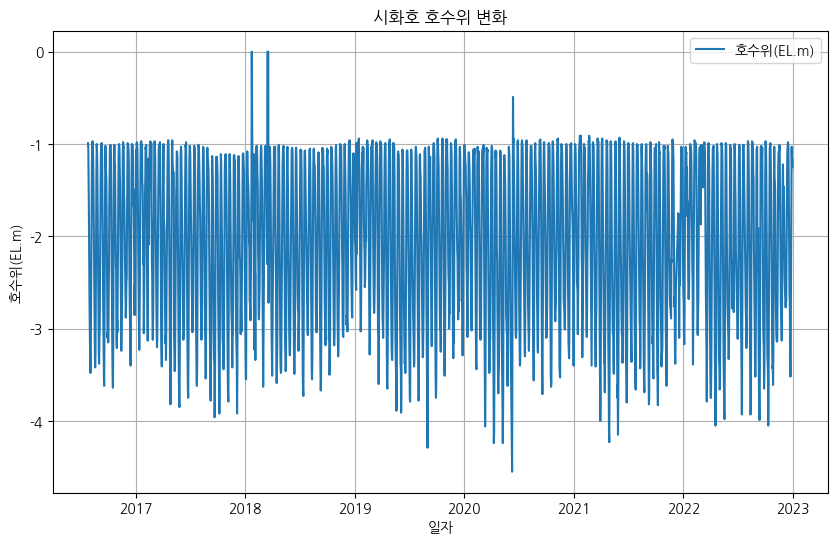

<Figure size 640x480 with 0 Axes>

In [60]:
# 호수위(EL.m) 시계열 데이터 시각화
plt.figure(figsize=(10, 6))
plt.plot(df1['일자'], df1['호수위(EL.m)'], label='호수위(EL.m)')
plt.xlabel('일자')
plt.ylabel('호수위(EL.m)')
plt.title('시화호 호수위 변화')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('시화호 호수위 변화.png')

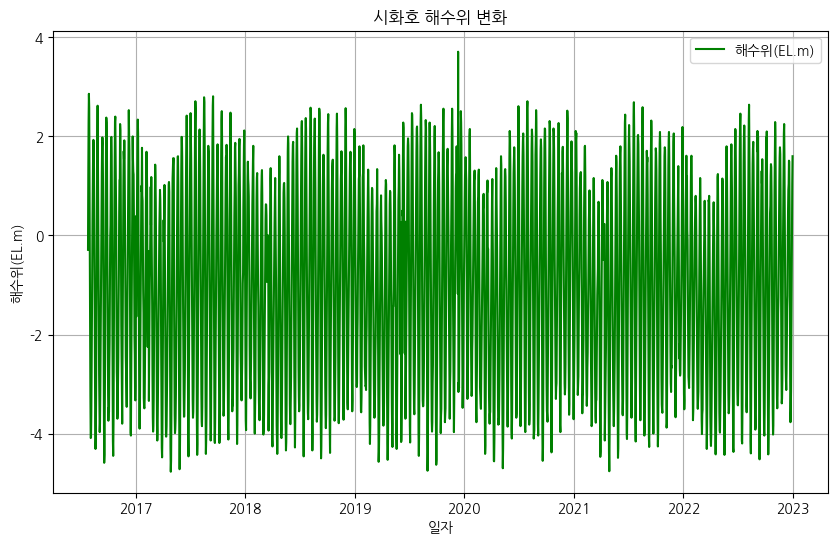

<Figure size 640x480 with 0 Axes>

In [59]:
# 해수위(EL.m) 시계열 데이터 시각화
plt.figure(figsize=(10, 6))
plt.plot(df1['일자'], df1['해수위(EL.m)'], label='해수위(EL.m)', c = 'g')
plt.xlabel('일자')
plt.ylabel('해수위(EL.m)')
plt.title('시화호 해수위 변화')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('시화호 해수위 변화.png')

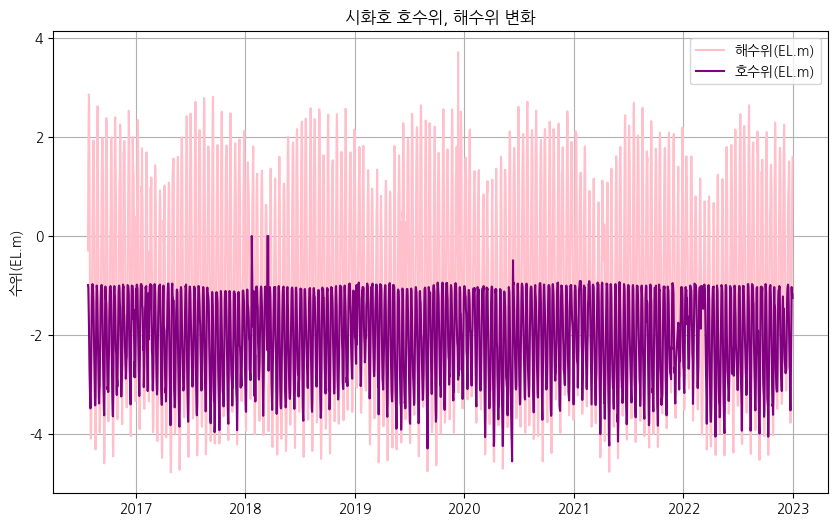

<Figure size 640x480 with 0 Axes>

In [66]:
# 호수위(EL.m), 해수위 시계열 데이터 한번에 시각화
plt.figure(figsize=(10, 6))


plt.plot(df1['일자'], df1['해수위(EL.m)'], label='해수위(EL.m)', c = 'pink')
plt.plot(df1['일자'], df1['호수위(EL.m)'], label='호수위(EL.m)', c = 'purple')

plt.ylabel('수위(EL.m)')
plt.title('시화호 호수위, 해수위 변화')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('시화호 해수위 호수위 변화.png')

In [46]:
# 주별 평균 기온 추가
df1['주별'] = df1['일자'].dt.strftime('%U')
weekly_temp = df1.groupby('주별')['평균기온(°C)'].mean().reset_index()


In [48]:
weekly_temp

,주별,평균기온(°C)
0,00,-3.972222
1,01,-2.769048
2,02,-2.078049
3,03,-3.104878
4,04,-1.542857
5,05,-2.495238
6,06,-0.752381
7,07,-0.532500
8,08,1.973810
9,09,3.748780


In [47]:
df1.head()

,일자,호수위(EL.m),해수위(EL.m),우량(mm),평균기온(°C),최저기온(°C),최고기온(°C),평균 풍속(m/s),주별
0,2022-12-31,-1.25,1.60,0.0,-3.8,-11.3,6.0,0.2,52
1,2022-12-30,-1.16,1.04,0.0,-4.6,-10.6,3.0,0.4,52
2,2022-12-29,-1.20,0.10,0.0,-4.9,-12.9,2.5,0.4,52
3,2022-12-28,-1.03,-0.91,0.0,-4.3,-10.0,1.8,0.7,52
4,2022-12-27,-1.76,-2.12,0.0,-5.4,-13.0,4.9,0.3,52


In [50]:
weekly_temp.rename(columns={'평균기온(°C)': '주별평균기온(°C)'}, inplace=True)

In [51]:
df1 = df1.merge(weekly_temp, on='주별', how='left')

In [52]:
# df1.drop(columns=['주별_x'], inplace=True)
df1.head()

,일자,호수위(EL.m),해수위(EL.m),우량(mm),평균기온(°C),최저기온(°C),최고기온(°C),평균 풍속(m/s),주별,주별평균기온(°C)
0,2022-12-31,-1.25,1.60,0.0,-3.8,-11.3,6.0,0.2,52,-3.102703
1,2022-12-30,-1.16,1.04,0.0,-4.6,-10.6,3.0,0.4,52,-3.102703
2,2022-12-29,-1.20,0.10,0.0,-4.9,-12.9,2.5,0.4,52,-3.102703
3,2022-12-28,-1.03,-0.91,0.0,-4.3,-10.0,1.8,0.7,52,-3.102703
4,2022-12-27,-1.76,-2.12,0.0,-5.4,-13.0,4.9,0.3,52,-3.102703


In [53]:
# 특성 선택
features = ['호수위(EL.m)', '해수위(EL.m)', '우량(mm)', '주별평균기온(°C)']

# 데이터 분할
X = df1[features]
y = df1['평균기온(°C)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
# 모델 훈련
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [55]:
# 예측
y_pred = model.predict(X_test)

# 평가
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 7.656115912297167


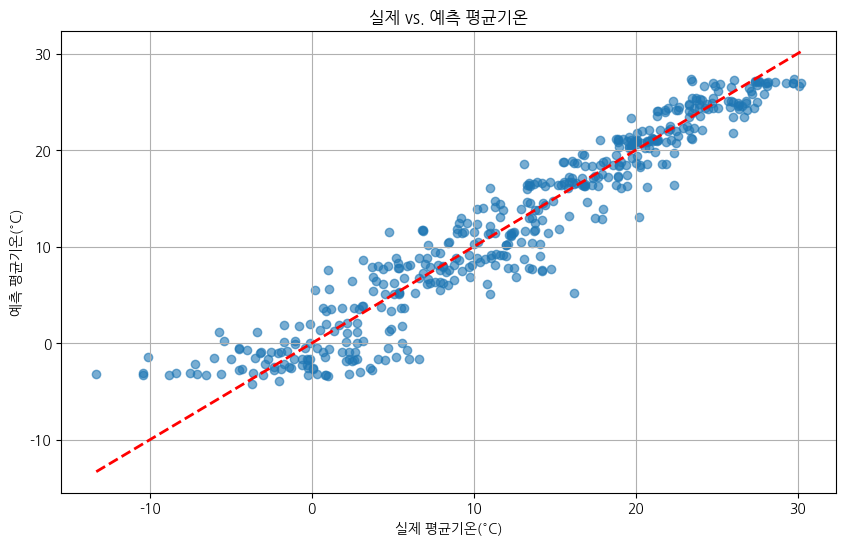

In [58]:
# 예측 결과 시각화
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)
plt.xlabel('실제 평균기온(°C)')
plt.ylabel('예측 평균기온(°C)')
plt.title('실제 vs. 예측 평균기온')
plt.savefig('실제vs예측평균기온.png')
plt.grid(True)
plt.show()

In [129]:
# 시계열분석
# ARIMA 모델
# 주어진 코드를 기반으로 ARIMA 모델 함수 정의합니다.
def arima_model(train, test):
    history = train.tolist()
    predictions = []

    for t in range(len(test)):
        model = ARIMA(history, order=(5, 1, 0))  # ARIMA(5,1,0) 모델 선택
        model_fit = model.fit()
        y_pred = model_fit.forecast()[0]
        predictions.append(y_pred)
        obs = test.iloc[t]
        history.append(obs)

    mse = mean_squared_error(test, predictions)
    return predictions, mse

In [128]:
# AR 모델
from statsmodels.tsa.ar_model import AutoReg

# 주어진 코드를 기반으로 AutoReg 모델 함수 정의합니다.
def predict_weekly_temperature(train, test):
    history = train['주별평균기온(°C)'].tolist()
    predictions = []

    for t in range(len(test)):
        model = AutoReg(history, lags=5)  # AR(5) 모델 선택
        model_fit = model.fit()
        y_pred = model_fit.predict(start=len(history), end=len(history))
        predictions.append(y_pred[0])
        obs = test.iloc[t]['주별평균기온(°C)']
        history.append(obs)

    mse = mean_squared_error(test['주별평균기온(°C)'], predictions)
    return predictions, mse


In [121]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2306 entries, 0 to 2305
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   일자          2306 non-null   datetime64[ns]
 1   호수위(EL.m)   2306 non-null   float64       
 2   해수위(EL.m)   2306 non-null   float64       
 3   우량(mm)      2306 non-null   float64       
 4   평균기온(°C)    2306 non-null   float64       
 5   최저기온(°C)    2306 non-null   float64       
 6   최고기온(°C)    2306 non-null   float64       
 7   평균 풍속(m/s)  2306 non-null   float64       
 8   주별          2306 non-null   object        
 9   주별평균기온(°C)  2306 non-null   float64       
dtypes: datetime64[ns](1), float64(8), object(1)
memory usage: 198.2+ KB


In [122]:
df1.head()

,일자,호수위(EL.m),해수위(EL.m),우량(mm),평균기온(°C),최저기온(°C),최고기온(°C),평균 풍속(m/s),주별,주별평균기온(°C)
0,2022-12-31,-1.25,1.60,0.0,-3.8,-11.3,6.0,0.2,52,-3.102703
1,2022-12-30,-1.16,1.04,0.0,-4.6,-10.6,3.0,0.4,52,-3.102703
2,2022-12-29,-1.20,0.10,0.0,-4.9,-12.9,2.5,0.4,52,-3.102703
3,2022-12-28,-1.03,-0.91,0.0,-4.3,-10.0,1.8,0.7,52,-3.102703
4,2022-12-27,-1.76,-2.12,0.0,-5.4,-13.0,4.9,0.3,52,-3.102703


In [123]:
# 학습 및 테스트 데이터 분할 (8:2 비율)
train = df1[:-500]
test = df1[:500]

# ARIMA 모델을 통한 주별 평균 기온 예측
arima_predictions, arima_mse = arima_model(train['주별평균기온(°C)'], test['주별평균기온(°C)'])

# AutoReg 모델을 통한 주별 평균 기온 예측
auto_reg_predictions, auto_reg_mse = predict_weekly_temperature(train, test)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

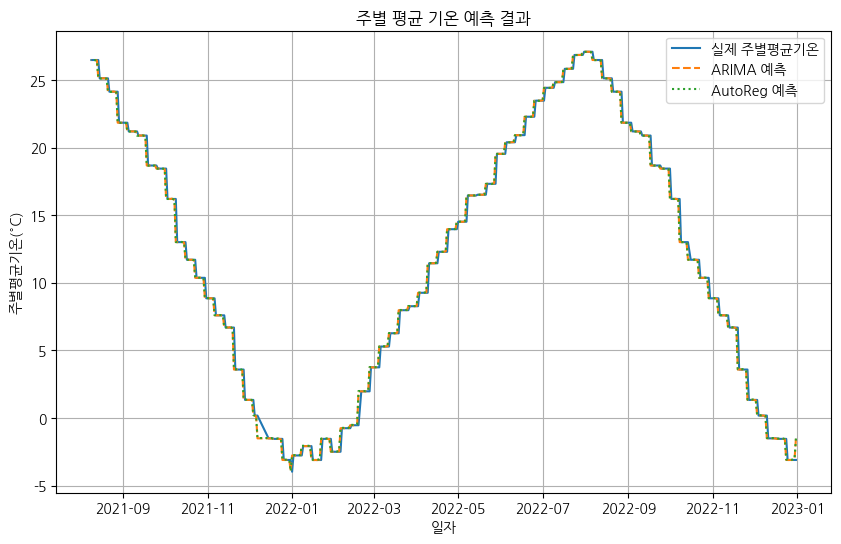

<Figure size 640x480 with 0 Axes>

In [124]:
# 시각화
plt.figure(figsize=(10, 6))
plt.plot(test['일자'], test['주별평균기온(°C)'], label='실제 주별평균기온')
plt.plot(test['일자'], arima_predictions, label='ARIMA 예측', linestyle='dashed')
plt.plot(test['일자'], auto_reg_predictions, label='AutoReg 예측', linestyle='dotted')
plt.xlabel('일자')
plt.ylabel('주별평균기온(°C)')
plt.title('주별 평균 기온 예측 결과')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('주별 평균 기온 예측 결과.png')

In [130]:
# MSE
print(f'ARIMA MSE: {arima_mse}')
print(f'AR MSE: {auto_reg_mse}')

ARIMA MSE: 0.34340831441912745
AR MSE: 0.34273293623114737
